In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error


In [2]:
### for Kaggle
# Ed
ed_img = '../input/echonet-image-ds/EchoNet/EchoNet/Frames/ED/'
ed_label = '../input/echonet-image-ds/EchoNet/EchoNet/Labels/ED/'

# Es
es_img = '../input/echonet-image-ds/EchoNet/EchoNet/Frames/ES/'
es_label = '../input/echonet-image-ds/EchoNet/EchoNet/Labels/ES/'

In [3]:
ed_x = []
for folder in  os.listdir(ed_img ) : 
    data = np.load(ed_img + folder)
    ed_x.append(data)
    

In [4]:
ed_y = []
for folder in  os.listdir(ed_label ) : 
    label = np.load(ed_label + folder)
    ed_y.append(label)
    

In [5]:
es_x = []
for folder in  os.listdir(es_img ) : 
    data = np.load(es_img + folder)
    es_x.append(data)
    

In [6]:
es_y = []
for folder in  os.listdir(es_label ) : 
    label = np.load(es_label + folder)
    es_y.append(label)
    

In [7]:
len(ed_x)

10024

In [8]:
ed_x=ed_x[:5000]
es_x=es_x[:5000]

In [9]:
ed_y=ed_y[:5000]
es_y=es_y[:5000]

In [10]:
#len(x)

In [11]:
ed_x = np.array(ed_x)
es_x = np.array(es_x)


In [12]:
ed_y = np.array(ed_y)
es_y = np.array(es_y)

In [13]:
data = np.vstack((ed_x, es_x))
label = np.vstack((ed_y ,es_y ))

In [14]:
del ed_x
del es_x
del ed_y
del es_y

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test1,y_train,y_test1 = train_test_split(data,label ,test_size = 0.3 ,random_state=100)

print(X_train.shape)
print(y_train.shape)
print("***********")
print(X_test1.shape)
print(y_test1.shape)

(7000, 112, 112, 3)
(7000, 112, 112, 1)
***********
(3000, 112, 112, 3)
(3000, 112, 112, 1)


In [16]:
from sklearn.model_selection import train_test_split

X_test,X_validate,y_test,y_validate = train_test_split(X_test1,y_test1 ,test_size = 0.5 ,random_state=100)

print(X_test.shape)
print(y_test.shape)
print("***********")
print(X_validate.shape)
print(y_validate.shape)

(1500, 112, 112, 3)
(1500, 112, 112, 1)
***********
(1500, 112, 112, 3)
(1500, 112, 112, 1)


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, MaxPooling2D, Concatenate , Dropout
from tensorflow.keras.models import Model
from tensorflow import keras

def conv_block(x,num_filters):
    
    x=Conv2D(num_filters,(5,5),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    
    x=Conv2D(num_filters,(3,3),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    
    x=Conv2D(num_filters,(3,3),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    
    return x
    

def build_model():
    size=112
    num_filters=[16,32,48,64]
    
    inputs=Input(shape=(size,size,3))
    skip_x=[]
    x=inputs
    
    #Encoder
    for f in num_filters:
        x=conv_block(x,f)
        skip_x.append(x)
        x=MaxPooling2D(2,2)(x)
        

    #bottleneck
    x=conv_block(x,num_filters[-1])
    
    num_filters.reverse()
    skip_x.reverse()
    
    #Decoder
    for i,f in enumerate(num_filters):
        x=UpSampling2D((2,2))(x)
        xs=skip_x[i]
        x=Concatenate()([x,xs])
        x=conv_block(x,f)
    #output
    x=Conv2D(1,(1,1),padding='same')(x)
    x=Activation('sigmoid')(x)
    return Model(inputs,x)


    

    

In [18]:
model=build_model()
model.summary()

2022-07-09 21:24:33.436366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 21:24:33.467372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 21:24:33.468169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 21:24:33.469588: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 16) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)
        
    

  


In [20]:
'''
from tensorflow.keras.utils import to_categorical
y_ttrain = to_categorical(y_train, 3)
y_ttest = to_categorical(y_test, 3)
'''

'\nfrom tensorflow.keras.utils import to_categorical\ny_ttrain = to_categorical(y_train, 3)\ny_ttest = to_categorical(y_test, 3)\n'

In [21]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

In [22]:
import tensorflow_addons as tfa
step = tf.Variable(0, trainable=False)

schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [1e-0, 1e-1, 1e-2])

lr = 1e-1 * schedule(step)
wd = lambda: 1e-4 * schedule(step)

optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

In [23]:
model.compile(optimizer=optimizer, loss=[dice_coef_loss], metrics=[dice_coef])


In [24]:
epochs = 20
history = model.fit(X_train,y_train,epochs=epochs, validation_data=(X_validate , y_validate))

2022-07-09 21:24:35.203698: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.
2022-07-09 21:24:36.395915: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 351232000 exceeds 10% of free system memory.
2022-07-09 21:24:36.788850: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.
2022-07-09 21:24:37.558633: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 351232000 exceeds 10% of free system memory.
2022-07-09 21:24:37.890485: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-09 21:24:41.889942: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


219/219 [==============================] - ETA: 0s - loss: 0.1733 - dice_coef: 0.8268

2022-07-09 21:24:59.599746: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 225792000 exceeds 10% of free system memory.


219/219 [==============================] - 24s 74ms/step - loss: 0.1733 - dice_coef: 0.8268 - val_loss: 0.1981 - val_dice_coef: 0.8019
Epoch 2/20
219/219 [==============================] - 15s 67ms/step - loss: 0.1034 - dice_coef: 0.8967 - val_loss: 0.1381 - val_dice_coef: 0.8619
Epoch 3/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0974 - dice_coef: 0.9026 - val_loss: 0.0989 - val_dice_coef: 0.9011
Epoch 4/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0936 - dice_coef: 0.9064 - val_loss: 0.1114 - val_dice_coef: 0.8885
Epoch 5/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0940 - dice_coef: 0.9060 - val_loss: 0.0979 - val_dice_coef: 0.9021
Epoch 6/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0910 - dice_coef: 0.9090 - val_loss: 0.0883 - val_dice_coef: 0.9117
Epoch 7/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0855 - dice_coef: 0.9145 - val_loss: 0.0882 - val_dice_co

Text(0, 0.5, 'Loss')

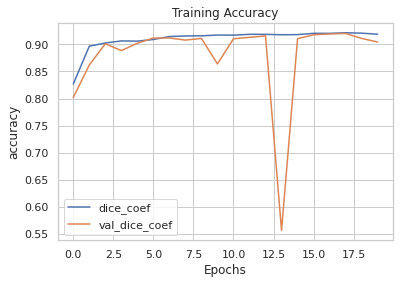

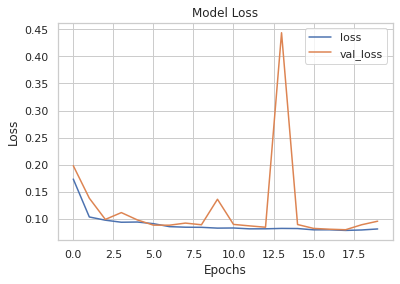

In [25]:
# converting hsitory to dataframe
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [26]:
 y_pred = model.predict(X_test)

In [29]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
12/12 [==============================] - 1s 79ms/step - loss: 0.0967 - dice_coef: 0.9030
test loss, test acc: [0.09666843712329865, 0.9030002951622009]
